# Imports

In [4]:
import pandas as pd
import numpy as np
np.random.seed(2121)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import BayesianRidge
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [5]:
batpos = pd.read_csv('../data/batpos_feature_extracted.csv')


In [6]:
batpos.drop(['name_common', 'player_id','g', 'team_gp', 'pa_pg', 'inn_pg',
       'runs_bat_pg', 'runs_br_pg', 'runs_dp_pg', 'runs_defense_pg',
       'runs_position_pg', 'opprpg', 'percent_team_gp', 'pa_per_team_gp',
       'inn_per_team_gp', 'g_c_share', 'g_1b_share', 'g_2b_share',
       'g_3b_share', 'g_ss_share', 'g_cf_share', 'g_dh_share', 'g_cof_share']
            , axis=1, inplace=True)

# Train-Test Split

In [18]:
batpos_target = 'waa_pg'


In [19]:
y = batpos[batpos_target]
X = batpos[[col for col in batpos.columns if col != batpos_target]]

In [20]:
X_train, X_test, y_train, y_test =\
    train_test_split(batpos_X, batpos_y,
                     test_size=0.2,
                     shuffle=True,
                     random_state = 1212)

## Standard Scale

In [21]:
# initialize
ss = StandardScaler()

# fit on Train
X_train_ss = pd.DataFrame(ss.fit_transform(X_train),
                              columns = X_train.columns,
                              index = X_train.index)

# transform test
X_test_ss = pd.DataFrame(ss.transform(X_test),
                         columns = X_test.columns,
                         index = X_test.index)



# RFE

In [22]:
rfecv = RFECV(
            estimator=BayesianRidge(),
            step = 1,
            cv = 5,
            scoring='r2',
            min_features_to_select = 10)

rfecv.fit(X_train_ss,y_train)

cols_to_keep = X_train_ss.T[rfecv.ranking_==1].T.columns
cols_to_pc = X_train_ss.T[rfecv.ranking_!=1].T.columns

print(f'# of Columns Kept: {len(cols_to_keep)}')
print(f'# of Columns Dropped: {len(cols_to_pc)}')

# of Columns Kept: 11
# of Columns Dropped: 57


# PCA

In [23]:
pca = PCA().fit(X_train_ss[cols_to_pc])

for i, l in enumerate(pca.explained_variance_[:6]):
    print('PC {}: {:.2f} --> {:.2f}%'.format(i, l,
                                             l * 100 / sum(pca.explained_variance_)))

PC 0: 8.57 --> 15.04%
PC 1: 5.45 --> 9.56%
PC 2: 4.28 --> 7.52%
PC 3: 3.43 --> 6.01%
PC 4: 3.30 --> 5.79%
PC 5: 3.13 --> 5.50%


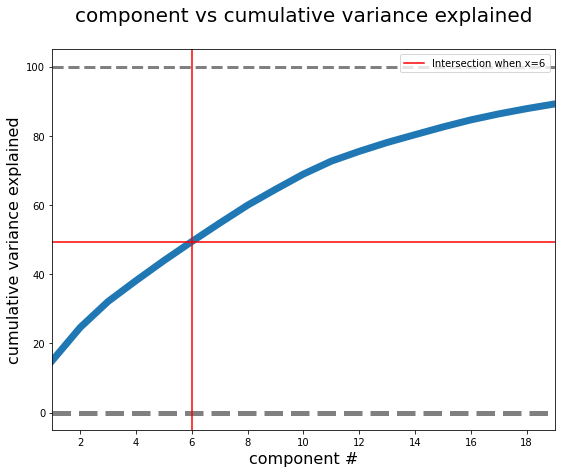

In [24]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(9,7))
component_number = range(1, len(cols_to_pc)+1)
plt.plot(component_number, cum_var_exp, lw=7)
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')
ax = plt.gca()
ax.set_xlim([1,19])
ax.set_ylim([-5,105])
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component #', fontsize=16)  
ax.set_title('component vs cumulative variance explained\n', fontsize=20)
ax.axhline(y=np.cumsum(pca.explained_variance_ratio_)[5]*100, c='r', label='Intersection when x=6')
ax.axvline(x=6,  c='r')
ax.legend();

In [25]:
pca_df_train = pd.DataFrame(pca.transform(X_train_ss[cols_to_pc])[:,:7],
                     columns = ['pc_' + str(i) for i in range(7)],
                     index = X_train_ss.index)

pca_df_test = pd.DataFrame(pca.transform(X_test_ss[cols_to_pc])[:,:7],
                     columns = ['pc_' + str(i) for i in range(7)],
                     index = X_test_ss.index)

In [26]:
X_train_ss = pd.concat([X_train_ss[cols_to_keep], pca_df_train], axis=1)

In [27]:
X_test_ss = pd.concat([X_test_ss[cols_to_keep], pca_df_test], axis=1)

# Export

In [ ]:
# X_train_ss.to_csv('../data/x_train_preprocessed.csv')
# y_train.to_csv('../data/y_train.csv')

# X_test_ss.to_csv('../data/x_test_preprocessed.csv')
# y_test.to_csv('../data/y_test.csv')

# base_train.to_csv('../data/baseline_train.csv')
# base_test.to_csv('../data/baseline_test.csv')